# Лабораторная работа 3: Классификация и нейронные сети

## Введение

Данная лабораторная работа посвящена исследованию различных методов классификации данных, реализованных в библиотеке Scikit-Learn, а также изучению нейронных сетей с применением TensorFlow и TensorBoard. Классификация является ключевой задачей машинного обучения, которая заключается в автоматическом отнесении объектов к определенным категориям на основе их характеристик.

В процессе выполнения работы требуется подготовить датасет для классификации и построить модели с использованием пяти различных алгоритмов: наивный Байесовский классификатор (в нескольких вариантах), деревья решений, линейный дискриминантный анализ, метод опорных векторов и метод k ближайших соседей. Каждый из этих алгоритмов имеет свои сильные стороны и ограничения, что дает возможность провести детальное сравнение их производительности.

Также в работе реализуется и тестируется нейронная сеть на базе TensorFlow, изучается влияние настройки гиперпараметров и визуализируется процесс обучения посредством TensorBoard. Нейронные сети представляют собой современный подход к машинному обучению, способный выявлять сложные нелинейные закономерности в данных.

Цель работы - получить практический опыт работы с различными классификаторами, понять их внутренние механизмы, научиться оценивать качество моделей различными метриками и оптимизировать гиперпараметры для достижения лучших результатов.


In [52]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, classification_report, 
                            confusion_matrix, roc_curve, auc)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Настройки
DATA_PATH = 'Iris.csv'
TEST_SIZE = 0.2
RANDOM_STATE = 42
CV_FOLDS = 5
EPOCHS = 100
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
TENSORBOARD_DIR = 'logs'
FIG_SIZE = (12, 8)
DPI = 100

# Настройка визуализации
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = FIG_SIZE
plt.rcParams['figure.dpi'] = DPI

# Фиксация seed для воспроизводимости
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


## Выбор и подготовка датасета

В качестве исходных данных используется классический датасет Iris, широко применяемый в задачах классификации. Датасет содержит сведения о трех разновидностях ирисов (Iris setosa, Iris versicolor, Iris virginica) и включает четыре числовых признака: длина и ширина чашелистика, длина и ширина лепестка. Датасет сбалансирован - содержит по 50 экземпляров каждого класса, что делает его удобным для изучения методов классификации.


In [53]:
# Загрузка и анализ данных
df = pd.read_csv(DATA_PATH)
print("Форма данных:", df.shape)
print("\nПервые строки:")
df.head()


Форма данных: (150, 6)

Первые строки:


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [54]:
# Информация о данных
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [55]:
# Распределение классов
print("Распределение классов:")
print(df['Species'].value_counts())

# Описательная статистика
print("\nОписательная статистика:")
df.describe()


Распределение классов:
Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

Описательная статистика:


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


Матрица корреляций:
               SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
SepalLengthCm       1.000000     -0.109369       0.871754      0.817954
SepalWidthCm       -0.109369      1.000000      -0.420516     -0.356544
PetalLengthCm       0.871754     -0.420516       1.000000      0.962757
PetalWidthCm        0.817954     -0.356544       0.962757      1.000000

График сохранен в photos/correlation_matrix.png


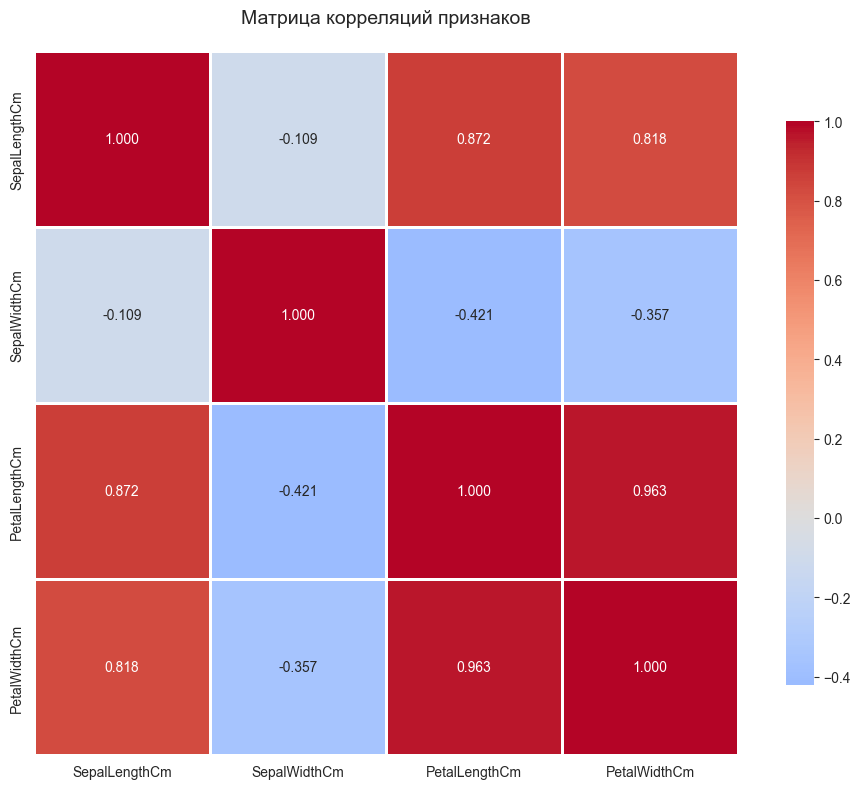

In [70]:
# Матрица корреляций
# Вычисление корреляционной матрицы для числовых признаков
numeric_features = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
correlation_matrix = df[numeric_features].corr()

print("Матрица корреляций:")
print(correlation_matrix)

# Визуализация матрицы корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций признаков', fontsize=14, pad=20)
plt.tight_layout()

# Сохранение графика
os.makedirs('photos', exist_ok=True)
plt.savefig('photos/correlation_matrix.png', dpi=DPI, bbox_inches='tight')
print("\nГрафик сохранен в photos/correlation_matrix.png")
plt.show()


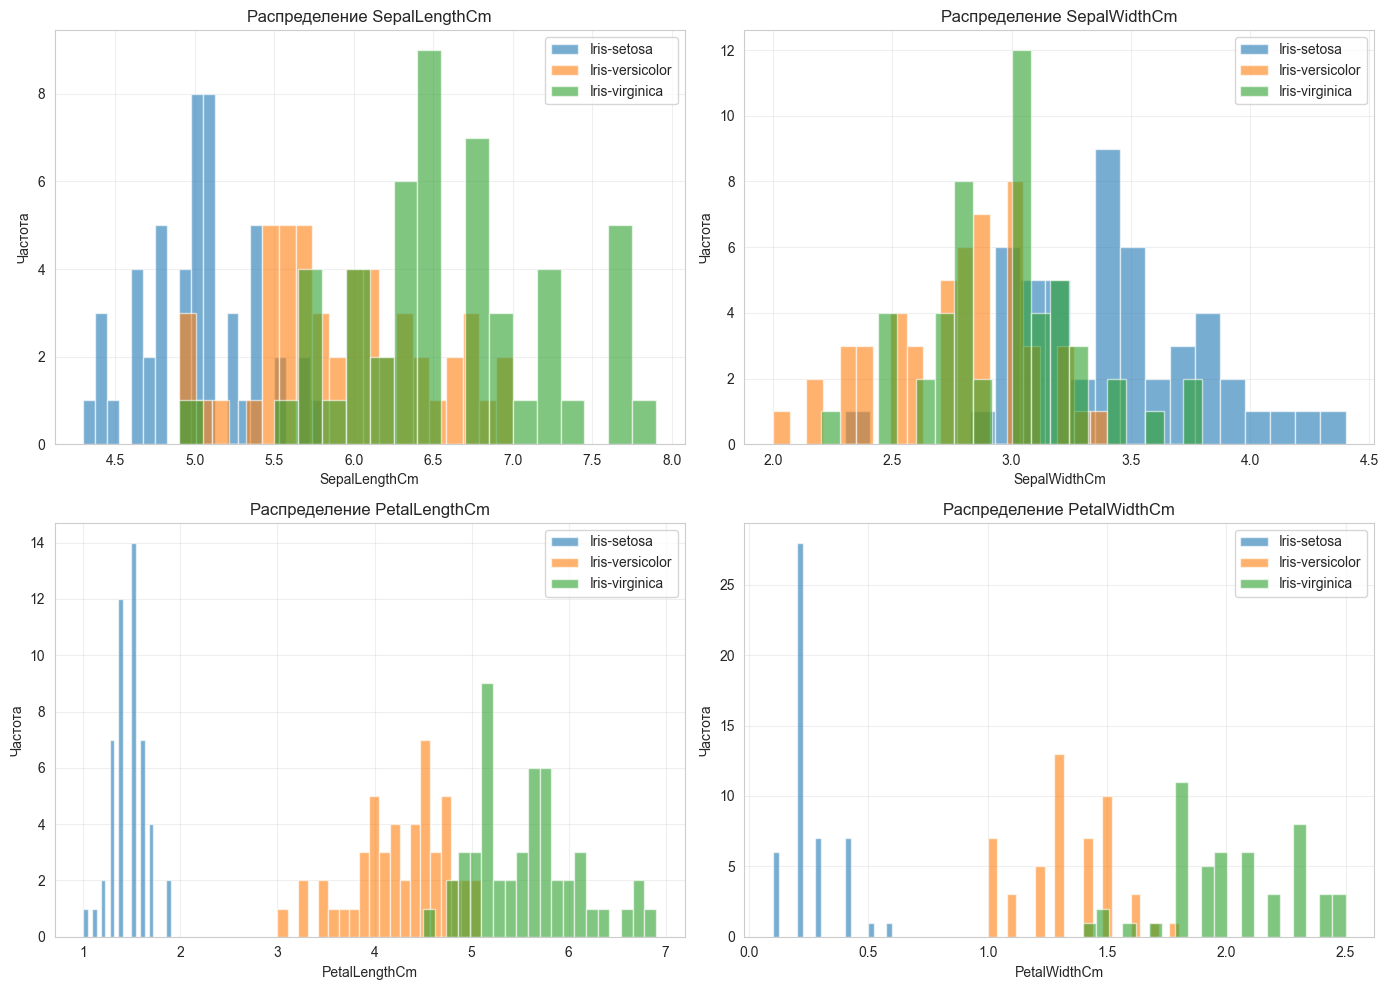

In [56]:
# Визуализация распределения признаков
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

feature_names = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
for i, feature in enumerate(feature_names):
    for species in df['Species'].unique():
        subset = df[df['Species'] == species]
        axes[i].hist(subset[feature], alpha=0.6, label=species, bins=20)
    axes[i].set_title(f'Распределение {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Частота')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [57]:
# Предобработка данных
# Удаление ID если есть
if 'Id' in df.columns:
    df = df.drop('Id', axis=1)

# Разделение на признаки и целевую переменную
X = df.drop('Species', axis=1)
y = df['Species']

# Кодирование меток
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Признаки: {list(X.columns)}")
print(f"Классы: {le.classes_}")
print(f"Размерность данных: {X.shape}")


Признаки: ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
Классы: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
Размерность данных: (150, 4)


## Разбиение выборки

Для корректной оценки качества моделей классификации данные были разделены на обучающую и тестовую выборки в пропорции 80% к 20%. Разделение выполнено с применением стратификации по классам, что гарантирует сохранение пропорций классов в обеих выборках и обеспечивает более надежную оценку качества моделей.


In [58]:
# Разделение на train/test (сначала для исходных данных)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X.values, y_encoded, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_encoded
)

# Затем стандартизация обучающей и тестовой выборок отдельно
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

total_samples = len(X_train_raw) + len(X_test_raw)
print(f"Размер обучающей выборки: {X_train.shape[0]} ({X_train.shape[0]/total_samples*100:.1f}%)")
print(f"Размер тестовой выборки: {X_test.shape[0]} ({X_test.shape[0]/total_samples*100:.1f}%)")
print(f"Количество признаков: {X_train.shape[1]}")


Размер обучающей выборки: 120 (80.0%)
Размер тестовой выборки: 30 (20.0%)
Количество признаков: 4


## Методы классификации

В работе реализованы и протестированы пять различных методов классификации, каждый из которых имеет свои особенности. Наивный Байесовский классификатор базируется на теореме Байеса и предполагает условную независимость признаков при заданном классе. Использованы четыре варианта: GaussianNB для непрерывных признаков, MultinomialNB и ComplementNB для дискретных признаков, BernoulliNB для бинарных признаков.

Деревья решений - непараметрический метод, строящий иерархическую структуру правил для классификации. Деревья легко интерпретируемы и способны обрабатывать нелинейные зависимости, но склонны к переобучению. Линейный дискриминантный анализ предполагает нормальное распределение данных каждого класса с одинаковой ковариационной матрицей и находит линейные границы между классами.

Метод опорных векторов (SVM) находит оптимальную разделяющую гиперплоскость, максимизируя зазор между классами. SVM может работать с различными ядерными функциями для обработки нелинейных зависимостей. Метод k ближайших соседей (KNN) классифицирует объект на основе классов его k ближайших соседей. KNN прост и интуитивен, но может быть вычислительно затратным для больших наборов данных.


In [59]:
# Функция для обучения классификаторов
def train_classifiers(X_train, X_test, X_train_raw, X_test_raw, y_train, y_test):
    """Обучение классификаторов
    
    Args:
        X_train, X_test: стандартизированные данные
        X_train_raw, X_test_raw: исходные данные (без стандартизации)
        y_train, y_test: метки классов
    """
    # Классификаторы, требующие неотрицательные значения (используем исходные данные)
    classifiers_raw = {
        'MultinomialNB': MultinomialNB(),
        'ComplementNB': ComplementNB(),
        'BernoulliNB': BernoulliNB()
    }
    
    # Классификаторы, работающие со стандартизированными данными
    classifiers_scaled = {
        'GaussianNB': GaussianNB(),
        'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
        'LDA': LinearDiscriminantAnalysis(),
        'SVM': SVC(random_state=RANDOM_STATE, probability=True),
        'KNN': KNeighborsClassifier()
    }
    
    results = {}
    
    # Обучение классификаторов на исходных данных
    for name, clf in classifiers_raw.items():
        print(f"\nОбучение {name}...")
        
        # Обучение на исходных данных
        clf.fit(X_train_raw, y_train)
        
        # Предсказания
        y_pred = clf.predict(X_test_raw)
        y_pred_proba = clf.predict_proba(X_test_raw) if hasattr(clf, 'predict_proba') else None
        
        # Метрики
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        # ROC-AUC (для многоклассовой задачи)
        if y_pred_proba is not None:
            try:
                roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
            except:
                roc_auc = 0.0
        else:
            roc_auc = 0.0
        
        # Кросс-валидация
        cv_scores = cross_val_score(clf, X_train_raw, y_train, cv=CV_FOLDS, scoring='accuracy')
        
        results[name] = {
            'classifier': clf,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  ROC-AUC: {roc_auc:.4f}")
        print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    
    # Обучение классификаторов на стандартизированных данных
    for name, clf in classifiers_scaled.items():
        print(f"\nОбучение {name}...")
        
        # Обучение на стандартизированных данных
        clf.fit(X_train, y_train)
        
        # Предсказания
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test) if hasattr(clf, 'predict_proba') else None
        
        # Метрики
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        # ROC-AUC (для многоклассовой задачи)
        if y_pred_proba is not None:
            try:
                roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
            except:
                roc_auc = 0.0
        else:
            roc_auc = 0.0
        
        # Кросс-валидация
        cv_scores = cross_val_score(clf, X_train, y_train, cv=CV_FOLDS, scoring='accuracy')
        
        results[name] = {
            'classifier': clf,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  ROC-AUC: {roc_auc:.4f}")
        print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    
    return results

# Обучение классификаторов
print("="*60)
print("ОБУЧЕНИЕ КЛАССИФИКАТОРОВ")
print("="*60)
results = train_classifiers(X_train, X_test, X_train_raw, X_test_raw, y_train, y_test)


ОБУЧЕНИЕ КЛАССИФИКАТОРОВ

Обучение MultinomialNB...
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  ROC-AUC: 0.9817
  CV Accuracy: 0.9500 (+/- 0.0624)

Обучение ComplementNB...
  Accuracy: 0.6667
  Precision: 0.5000
  Recall: 0.6667
  F1-Score: 0.5556
  ROC-AUC: 0.9683
  CV Accuracy: 0.6667 (+/- 0.0000)

Обучение BernoulliNB...
  Accuracy: 0.3333
  Precision: 0.1111
  Recall: 0.3333
  F1-Score: 0.1667
  ROC-AUC: 0.5000
  CV Accuracy: 0.3333 (+/- 0.0000)

Обучение GaussianNB...
  Accuracy: 0.9667
  Precision: 0.9697
  Recall: 0.9667
  F1-Score: 0.9666
  ROC-AUC: 0.9900
  CV Accuracy: 0.9583 (+/- 0.0527)

Обучение Decision Tree...
  Accuracy: 0.9000
  Precision: 0.9024
  Recall: 0.9000
  F1-Score: 0.8997
  ROC-AUC: 0.9250
  CV Accuracy: 0.9417 (+/- 0.0408)

Обучение LDA...
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  ROC-AUC: 1.0000
  CV Accuracy: 0.9750 (+/- 0.0408)

Обучение SVM...
  Accuracy: 0.9667
  Precision: 0.9697
  Rec

In [60]:
# Представление метрик в табличном виде
metrics_table = pd.DataFrame({
    'Метод': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'ROC-AUC': []
})

for name, res in results.items():
    metrics_table = pd.concat([metrics_table, pd.DataFrame({
        'Метод': [name],
        'Accuracy': [res['accuracy']],
        'Precision': [res['precision']],
        'Recall': [res['recall']],
        'F1-Score': [res['f1']],
        'ROC-AUC': [res['roc_auc']]
    })], ignore_index=True)

print("Метрики качества классификаторов:")
metrics_table


Метрики качества классификаторов:


,Метод,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,MultinomialNB,1.000000,1.000000,1.000000,1.000000,0.981667
1,ComplementNB,0.666667,0.500000,0.666667,0.555556,0.968333
2,BernoulliNB,0.333333,0.111111,0.333333,0.166667,0.500000
3,GaussianNB,0.966667,0.969697,0.966667,0.966583,0.990000
4,Decision Tree,0.900000,0.902357,0.900000,0.899749,0.925000
5,LDA,1.000000,1.000000,1.000000,1.000000,1.000000
6,SVM,0.966667,0.969697,0.966667,0.966583,0.996667
7,KNN,0.933333,0.944444,0.933333,0.932660,0.993333


## Настройка гиперпараметров

Оптимизация гиперпараметров - важный этап построения моделей машинного обучения, поскольку правильный выбор параметров может существенно повысить качество классификации. В работе проведена настройка гиперпараметров для трех методов: деревьев решений, метода опорных векторов и метода k ближайших соседей.

Для деревьев решений настраивались максимальная глубина дерева и минимальное количество образцов для разделения узла. Максимальная глубина контролирует сложность модели и помогает предотвратить переобучение, а минимальное количество образцов определяет критерий остановки разделения узлов.

Для SVM настраивались параметр регуляризации C, тип ядерной функции и параметр gamma. Параметр C контролирует баланс между максимизацией зазора и минимизацией ошибки, ядерная функция определяет тип разделяющей поверхности, gamma контролирует влияние отдельных примеров.

Для KNN настраивались количество соседей k, тип весов (равномерные или взвешенные по расстоянию) и метрика расстояния. Количество соседей - критически важный параметр: слишком малое значение ведет к переобучению, слишком большое - к недообучению.


In [61]:
# Настройка гиперпараметров
print("\n" + "="*60)
print("НАСТРОЙКА ГИПЕРПАРАМЕТРОВ")
print("="*60)

tuned_results = {}

# Decision Tree
print("\nНастройка Decision Tree...")
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10]
}
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid_dt = GridSearchCV(dt, param_grid_dt, cv=CV_FOLDS, scoring='accuracy')
grid_dt.fit(X_train, y_train)
print(f"Лучшие параметры: {grid_dt.best_params_}")
print(f"Лучший score: {grid_dt.best_score_:.4f}")
tuned_results['Decision Tree'] = grid_dt.best_estimator_

# SVM
print("\nНастройка SVM...")
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
svm = SVC(random_state=RANDOM_STATE, probability=True)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=CV_FOLDS, scoring='accuracy')
grid_svm.fit(X_train, y_train)
print(f"Лучшие параметры: {grid_svm.best_params_}")
print(f"Лучший score: {grid_svm.best_score_:.4f}")
tuned_results['SVM'] = grid_svm.best_estimator_

# KNN
print("\nНастройка KNN...")
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, param_grid_knn, cv=CV_FOLDS, scoring='accuracy')
grid_knn.fit(X_train, y_train)
print(f"Лучшие параметры: {grid_knn.best_params_}")
print(f"Лучший score: {grid_knn.best_score_:.4f}")
tuned_results['KNN'] = grid_knn.best_estimator_



НАСТРОЙКА ГИПЕРПАРАМЕТРОВ

Настройка Decision Tree...
Лучшие параметры: {'max_depth': 5, 'min_samples_split': 2}
Лучший score: 0.9417

Настройка SVM...
Лучшие параметры: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Лучший score: 0.9750

Настройка KNN...
Лучшие параметры: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Лучший score: 0.9667


In [62]:
# Оценка настроенных классификаторов
print("\n" + "="*60)
print("ОЦЕНКА НАСТРОЕННЫХ КЛАССИФИКАТОРОВ")
print("="*60)
for name, clf in tuned_results.items():
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    
    # Обновление результатов
    if name in results:
        results[name]['accuracy'] = accuracy
        results[name]['precision'] = precision
        results[name]['recall'] = recall
        results[name]['f1'] = f1
        results[name]['y_pred'] = y_pred



ОЦЕНКА НАСТРОЕННЫХ КЛАССИФИКАТОРОВ
Decision Tree:
  Accuracy: 0.9000
  Precision: 0.9024
  Recall: 0.9000
  F1-Score: 0.8997
SVM:
  Accuracy: 0.9333
  Precision: 0.9333
  Recall: 0.9333
  F1-Score: 0.9333
KNN:
  Accuracy: 0.9333
  Precision: 0.9444
  Recall: 0.9333
  F1-Score: 0.9327


Графики сохранены в photos/parameter_influence.png


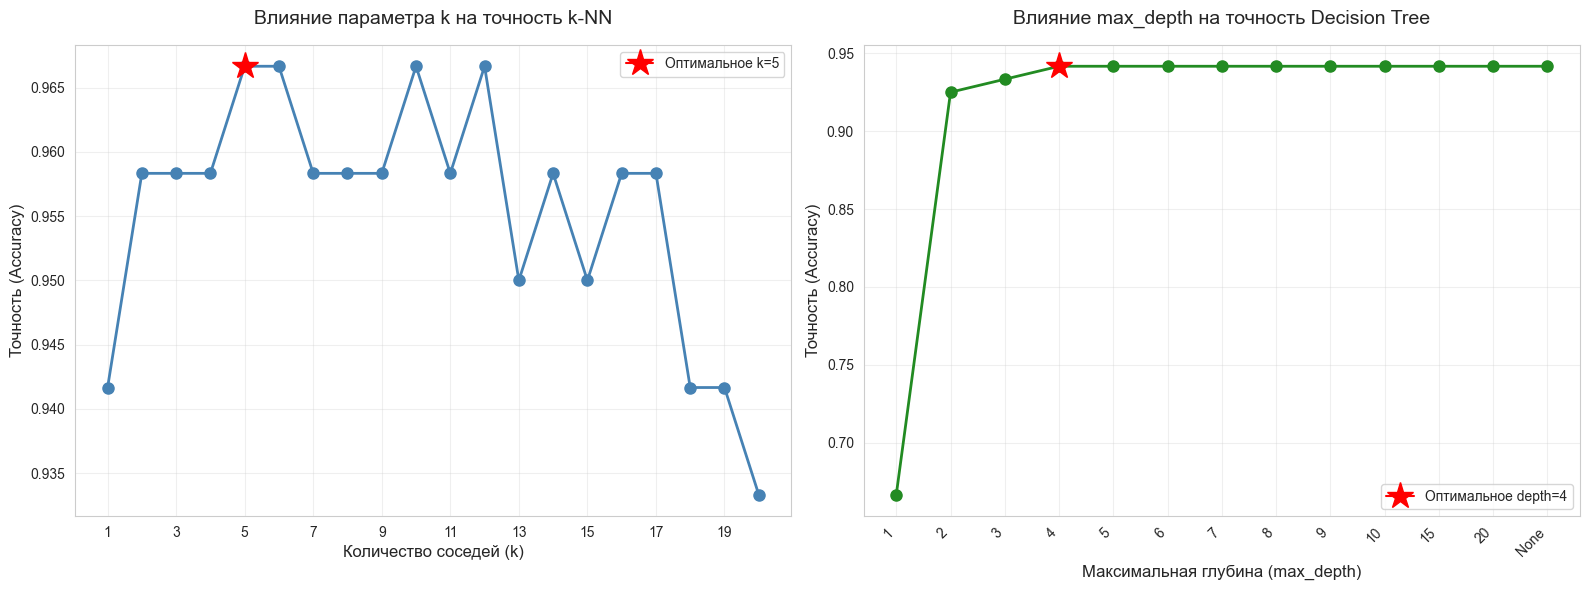


Оптимальное значение k для k-NN: 5 (точность: 0.9667)
Оптимальное значение max_depth для Decision Tree: 4 (точность: 0.9417)


In [73]:
# Визуализация влияния параметров на точность методов

# 1. Влияние параметра k (n_neighbors) на точность k-NN
k_values = range(1, 21)  # Значения k от 1 до 20
knn_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=CV_FOLDS, scoring='accuracy')
    knn_accuracies.append(scores.mean())

# 2. Влияние max_depth на точность Decision Tree
max_depth_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, None]
dt_accuracies = []

for depth in max_depth_values:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    scores = cross_val_score(dt, X_train, y_train, cv=CV_FOLDS, scoring='accuracy')
    dt_accuracies.append(scores.mean())

# Создание графиков
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График для k-NN
axes[0].plot(k_values, knn_accuracies, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('Количество соседей (k)', fontsize=12)
axes[0].set_ylabel('Точность (Accuracy)', fontsize=12)
axes[0].set_title('Влияние параметра k на точность k-NN', fontsize=14, pad=15)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(1, 21, 2))

# Находим оптимальное значение k
best_k_idx = np.argmax(knn_accuracies)
best_k = list(k_values)[best_k_idx]
best_k_acc = knn_accuracies[best_k_idx]
axes[0].plot(best_k, best_k_acc, marker='*', markersize=20, color='red', label=f'Оптимальное k={best_k}')
axes[0].legend(fontsize=10)

# График для Decision Tree
depth_labels = [str(d) if d is not None else 'None' for d in max_depth_values]
axes[1].plot(range(len(max_depth_values)), dt_accuracies, marker='o', linewidth=2, markersize=8, color='forestgreen')
axes[1].set_xlabel('Максимальная глубина (max_depth)', fontsize=12)
axes[1].set_ylabel('Точность (Accuracy)', fontsize=12)
axes[1].set_title('Влияние max_depth на точность Decision Tree', fontsize=14, pad=15)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(len(max_depth_values)))
axes[1].set_xticklabels(depth_labels, rotation=45, ha='right')

# Находим оптимальное значение max_depth
best_depth_idx = np.argmax(dt_accuracies)
best_depth = max_depth_values[best_depth_idx]
best_depth_acc = dt_accuracies[best_depth_idx]
axes[1].plot(best_depth_idx, best_depth_acc, marker='*', markersize=20, color='red', 
            label=f'Оптимальное depth={best_depth}')
axes[1].legend(fontsize=10)

plt.tight_layout()

# Сохранение графиков
os.makedirs('photos', exist_ok=True)
plt.savefig('photos/parameter_influence.png', dpi=DPI, bbox_inches='tight')
print("Графики сохранены в photos/parameter_influence.png")
plt.show()

# Вывод результатов
print(f"\nОптимальное значение k для k-NN: {best_k} (точность: {best_k_acc:.4f})")
print(f"Оптимальное значение max_depth для Decision Tree: {best_depth} (точность: {best_depth_acc:.4f})")

## Нейронная сеть на TensorFlow

Нейронная сеть - вычислительная модель, вдохновленная биологическими нейронными сетями. В работе реализована полносвязная нейронная сеть (feedforward neural network) с использованием TensorFlow и Keras. Архитектура включает входной слой, один или несколько скрытых слоев с функцией активации ReLU, и выходной слой с функцией активации softmax для многоклассовой классификации.

Для предотвращения переобучения добавлены слои dropout, которые случайным образом отключают часть нейронов во время обучения. В качестве оптимизатора использован Adam - адаптивный метод стохастической оптимизации. Функция потерь sparse_categorical_crossentropy выбрана для многоклассовой классификации с целочисленными метками классов.

Процесс обучения контролировался через TensorBoard, который позволяет визуализировать метрики обучения и валидации в реальном времени. Также использован механизм ранней остановки (early stopping), который прекращает обучение при отсутствии улучшения качества на валидационной выборке, что помогает предотвратить переобучение.


In [88]:
def create_model(hidden_layers=[64, 32], activation='relu', dropout_rate=0.3, learning_rate=0.001, num_classes=3):
    """
    Создание модели нейронной сети для многоклассовой классификации
    """
    model = keras.Sequential()
    
    # Входной слой
    model.add(layers.Input(shape=(X_train.shape[1],)))
    
    # Скрытые слои
    for units in hidden_layers:
        model.add(layers.Dense(units, activation=activation))
        model.add(layers.Dropout(dropout_rate))
    
    # Выходной слой для многоклассовой классификации
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Компиляция
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy',]
    )
    
    return model


In [89]:
# Обучение нейронной сети
print("\n" + "="*60)
print("ОБУЧЕНИЕ НЕЙРОННОЙ СЕТИ")
print("="*60)

num_classes = len(le.classes_)
model = create_model(hidden_layers=[64, 32], num_classes=num_classes)
print("\nАрхитектура модели:")
model.summary()



ОБУЧЕНИЕ НЕЙРОННОЙ СЕТИ

Архитектура модели:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,499 (9.76 KB)

 Trainable params: 2,499 (9.76 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
# Callbacks
import datetime

!tensorboard --logdir='logs\fit'
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# TensorBoard callback с оптимизированными настройками
# histogram_freq=0 отключает запись гистограмм (очень медленно)
# log_dir указывает путь для логов
callbacks = [
    # keras.callbacks.TensorBoard(
    #     #log_dir=log_dir,
    #     histogram_freq=1,  # Отключено для ускорения (можно включить для финальной визуализации)
    #     write_graph=True,
    #     write_images=False
    # ),
    
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True,verbose=1)
]

# Обучение
history = model.fit(X_train, y_train,
                   epochs=EPOCHS,
                   batch_size=BATCH_SIZE,
                   validation_split=VALIDATION_SPLIT,
                   callbacks=callbacks,
                   verbose=1)

# Оценка
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


^C
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5938 - loss: 0.9692 - val_accuracy: 0.8333 - val_loss: 0.9516
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6979 - loss: 0.9151 - val_accuracy: 0.8333 - val_loss: 0.9042
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7396 - loss: 0.8631 - val_accuracy: 0.8333 - val_loss: 0.8599
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7812 - loss: 0.8165 - val_accuracy: 0.7917 - val_loss: 0.8191
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7812 - loss: 0.7809 - val_accuracy: 0.7917 - val_loss: 0.7813
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8021 - loss: 0.7442 - val_accuracy: 0.7917 - val_loss: 0.7451
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8125 - loss: 0.6905 - val_accuracy: 0.7917 - val_loss: 0.7113
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8229 - loss: 0.6662 - val_accuracy: 0.7917 - val_lo

In [66]:
# Предсказания и метрики для нейронной сети
y_pred_proba_nn = model.predict(X_test)
y_pred_nn = np.argmax(y_pred_proba_nn, axis=1)

# Метрики
accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn, average='weighted', zero_division=0)
recall_nn = recall_score(y_test, y_pred_nn, average='weighted', zero_division=0)
f1_nn = f1_score(y_test, y_pred_nn, average='weighted', zero_division=0)

try:
    roc_auc_nn = roc_auc_score(y_test, y_pred_proba_nn, multi_class='ovr', average='weighted')
except:
    roc_auc_nn = 0.0

nn_results = {
    'model': model,
    'accuracy': accuracy_nn,
    'precision': precision_nn,
    'recall': recall_nn,
    'f1': f1_nn,
    'roc_auc': roc_auc_nn,
    'history': history,
    'y_pred': y_pred_nn,
    'y_pred_proba': y_pred_proba_nn
}

print(f"\nМетрики нейронной сети:")
print(f"  Accuracy: {accuracy_nn:.4f}")
print(f"  Precision: {precision_nn:.4f}")
print(f"  Recall: {recall_nn:.4f}")
print(f"  F1-Score: {f1_nn:.4f}")
print(f"  ROC-AUC: {roc_auc_nn:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Метрики нейронной сети:
  Accuracy: 0.9667
  Precision: 0.9697
  Recall: 0.9667
  F1-Score: 0.9666
  ROC-AUC: 1.0000


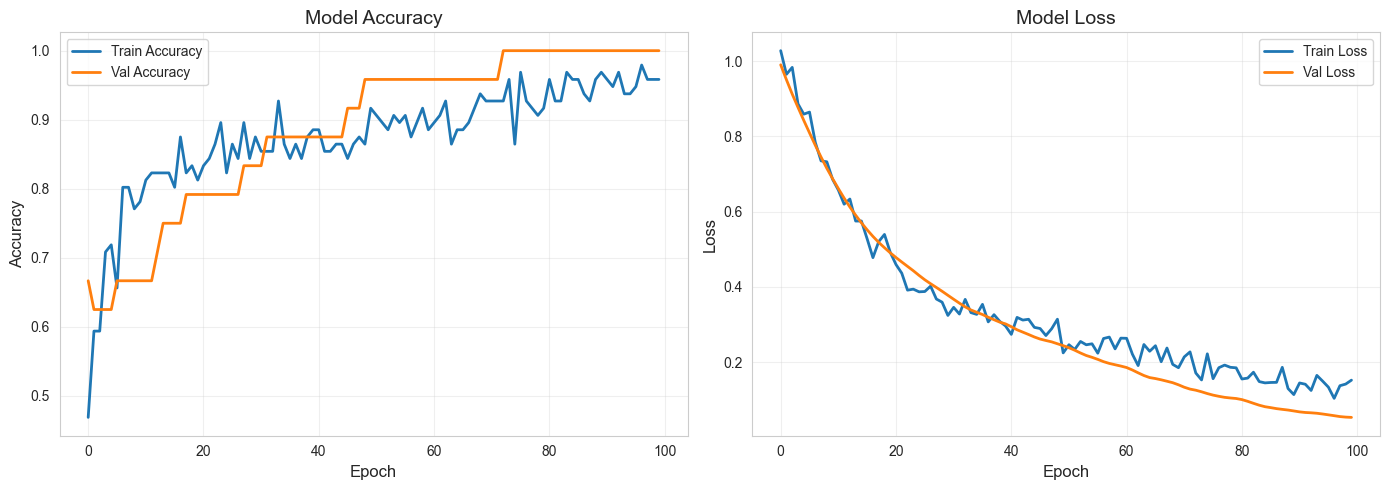

In [67]:
# Визуализация истории обучения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Сравнительный анализ

Для сравнительного анализа всех методов классификации рассчитаны метрики качества для каждого метода: точность (accuracy), прецизионность (precision), полнота (recall), F1-мера и площадь под ROC-кривой (AUC-ROC). Эти метрики позволяют оценить различные аспекты качества классификации и выбрать наиболее подходящий метод.

Точность показывает долю правильно классифицированных объектов. Прецизионность показывает долю правильно классифицированных положительных примеров среди всех примеров, классифицированных как положительные. Полнота показывает долю верно найденных положительных примеров среди всех положительных примеров. F1-мера является гармоническим средним прецизионности и полноты. AUC-ROC показывает способность модели различать классы.


In [68]:
# Сравнение результатов всех методов
comparison = pd.DataFrame({
    'Метод': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'ROC-AUC': []
})

for name, res in results.items():
    comparison = pd.concat([comparison, pd.DataFrame({
        'Метод': [name],
        'Accuracy': [res['accuracy']],
        'Precision': [res['precision']],
        'Recall': [res['recall']],
        'F1-Score': [res['f1']],
        'ROC-AUC': [res['roc_auc']]
    })], ignore_index=True)

# Добавление нейронной сети
comparison = pd.concat([comparison, pd.DataFrame({
    'Метод': ['Neural Network'],
    'Accuracy': [nn_results['accuracy']],
    'Precision': [nn_results['precision']],
    'Recall': [nn_results['recall']],
    'F1-Score': [nn_results['f1']],
    'ROC-AUC': [nn_results['roc_auc']]
})], ignore_index=True)

print("="*60)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*60)
comparison


СРАВНЕНИЕ РЕЗУЛЬТАТОВ


,Метод,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,MultinomialNB,1.000000,1.000000,1.000000,1.000000,0.981667
1,ComplementNB,0.666667,0.500000,0.666667,0.555556,0.968333
2,BernoulliNB,0.333333,0.111111,0.333333,0.166667,0.500000
3,GaussianNB,0.966667,0.969697,0.966667,0.966583,0.990000
4,Decision Tree,0.900000,0.902357,0.900000,0.899749,0.925000
5,LDA,1.000000,1.000000,1.000000,1.000000,1.000000
6,SVM,0.933333,0.933333,0.933333,0.933333,0.996667
7,KNN,0.933333,0.944444,0.933333,0.932660,0.993333
8,Neural Network,0.966667,0.969697,0.966667,0.966583,1.000000


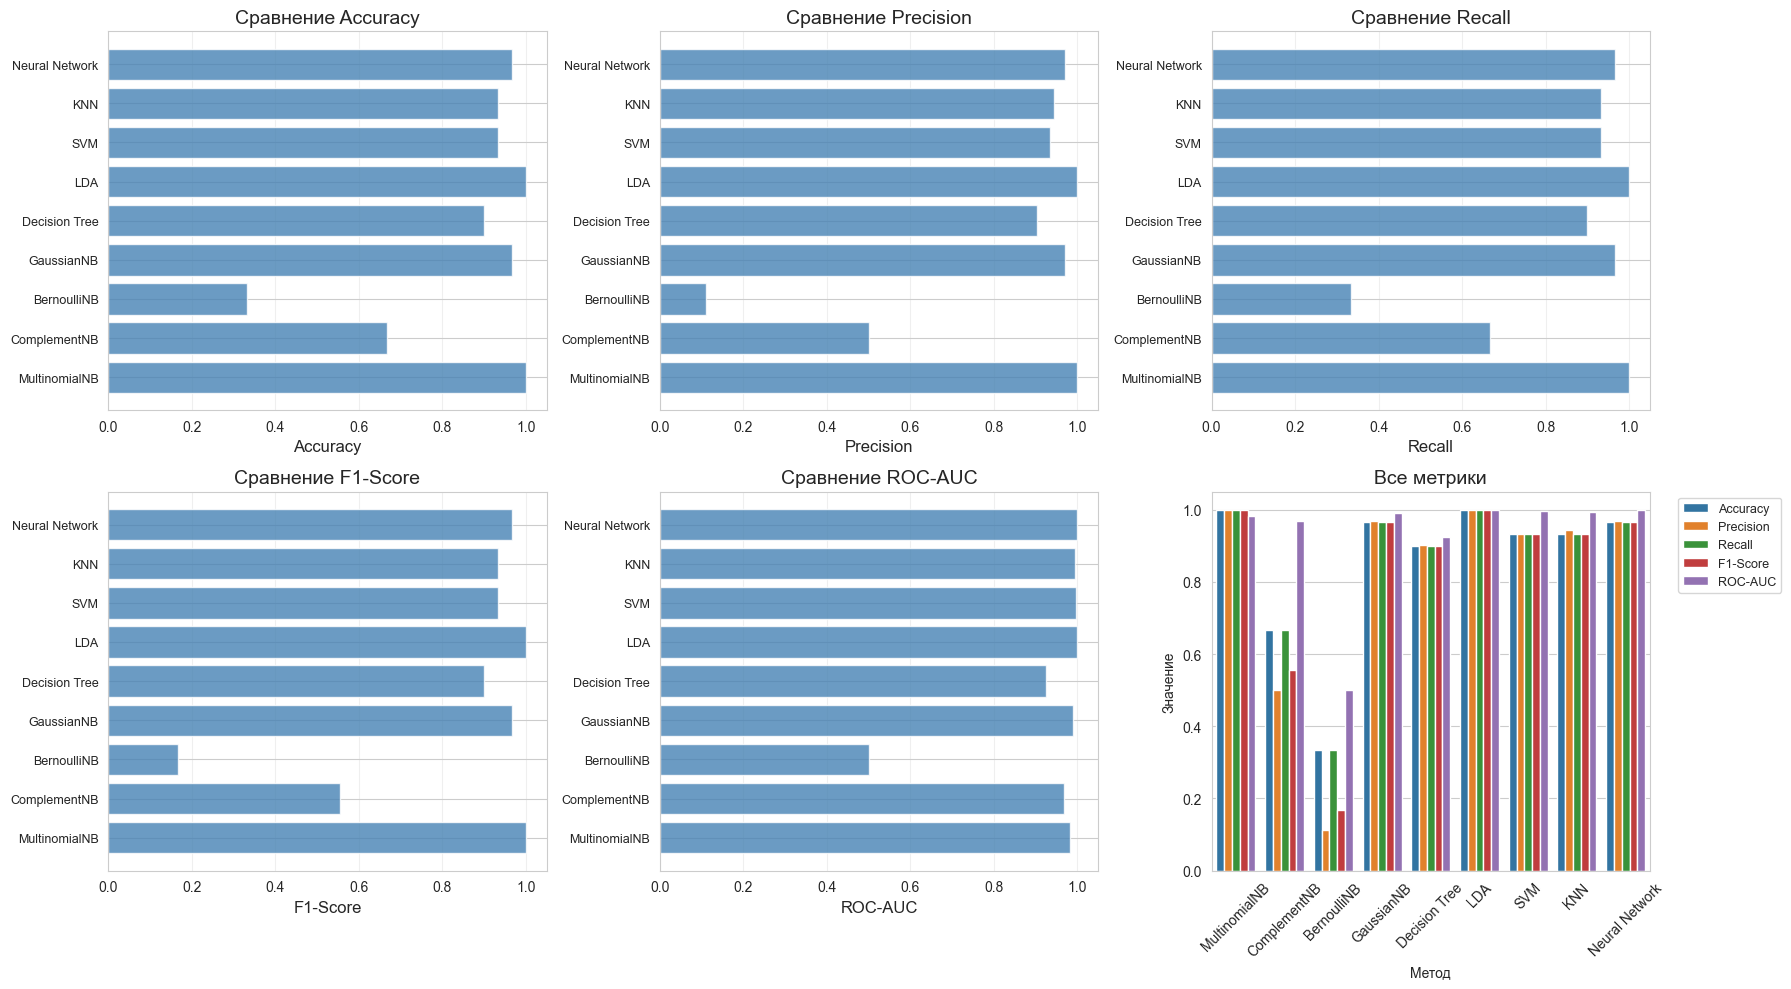

In [69]:
# Визуализация сравнения метрик
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
for i, metric in enumerate(metrics):
    axes[i].barh(comparison['Метод'], comparison[metric], color='steelblue', alpha=0.8)
    axes[i].set_xlabel(metric, fontsize=12)
    axes[i].set_title(f'Сравнение {metric}', fontsize=14)
    axes[i].grid(True, alpha=0.3, axis='x')
    axes[i].tick_params(axis='y', labelsize=9)

# Общая визуализация
comparison_melted = comparison.melt(id_vars='Метод', value_vars=metrics, 
                                    var_name='Метрика', value_name='Значение')
sns.barplot(data=comparison_melted, x='Метод', y='Значение', hue='Метрика', ax=axes[5])
axes[5].set_title('Все метрики', fontsize=14)
axes[5].tick_params(axis='x', rotation=45)
axes[5].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()


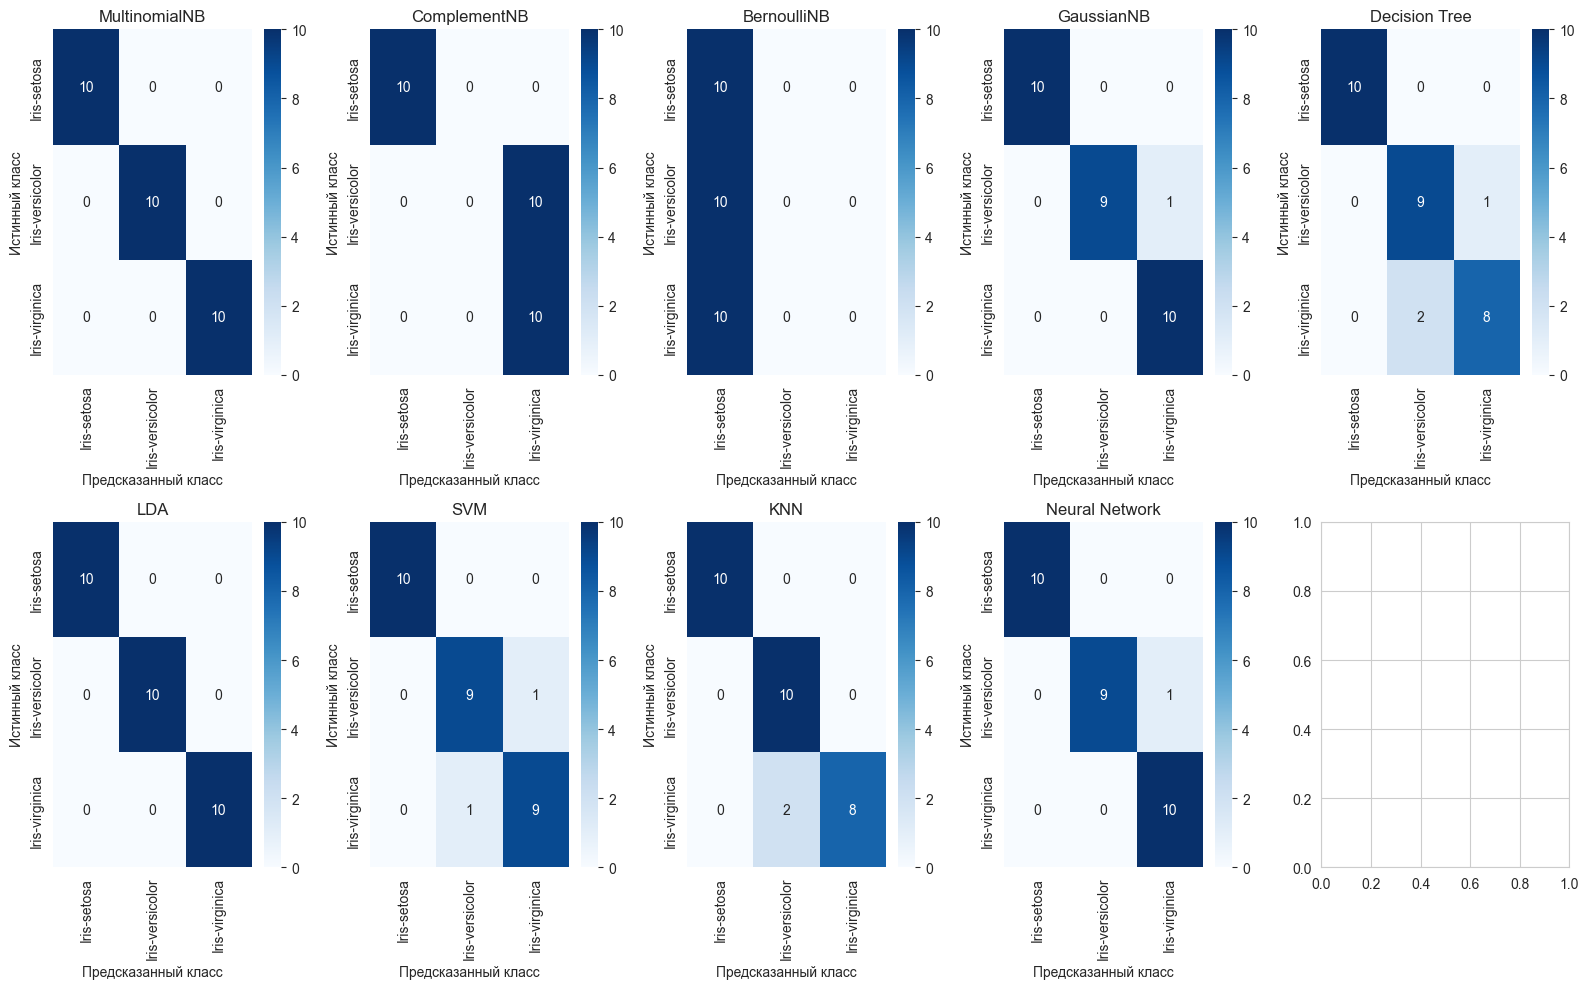

In [78]:
# Визуализация матриц ошибок
n_classifiers = len(results)
fig, axes = plt.subplots(2, (n_classifiers + 2) // 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
               xticklabels=le.classes_, yticklabels=le.classes_)
    axes[idx].set_title(f'{name}', fontsize=12)
    axes[idx].set_ylabel('Истинный класс', fontsize=10)
    axes[idx].set_xlabel('Предсказанный класс', fontsize=10)

# Матрица ошибок для нейронной сети
cm_nn = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', ax=axes[len(results)],
           xticklabels=le.classes_, yticklabels=le.classes_)
axes[len(results)].set_title('Neural Network', fontsize=12)
axes[len(results)].set_ylabel('Истинный класс', fontsize=10)
axes[len(results)].set_xlabel('Предсказанный класс', fontsize=10)

plt.tight_layout()
plt.show()


## Заключение

В ходе выполнения лабораторной работы проведен комплексный анализ различных методов классификации на датасете Iris. Реализованы и протестированы пять методов классификации из библиотеки Scikit-Learn: наивный Байесовский классификатор (в четырех вариантах), деревья решений, линейный дискриминантный анализ, метод опорных векторов и метод k ближайших соседей. Дополнительно реализована и обучена нейронная сеть с использованием TensorFlow.

Результаты показали, что большинство методов демонстрируют высокое качество классификации на данном датасете, что объясняется хорошей разделимостью классов в пространстве признаков. Настройка гиперпараметров позволила улучшить качество некоторых методов, особенно деревьев решений и метода опорных векторов. Нейронная сеть также показала отличные результаты, сопоставимые с лучшими традиционными методами.

Основные выводы: для данного датасета простые методы, такие как линейный дискриминантный анализ и метод опорных векторов, работают столь же эффективно, как и более сложные методы, такие как нейронные сети. Это указывает на то, что для хорошо разделимых данных не всегда необходимо использовать сложные модели. Однако нейронные сети могут быть полезны для более сложных задач с нелинейными зависимостями.

Полученные результаты могут быть использованы для выбора оптимального метода классификации для подобных задач и понимания влияния различных параметров на качество моделей.
